In [2]:
#environment. matplotlib print in the output block 
%matplotlib inline
#set up, main tools= np,pd,tf
import numpy as np
import pandas as pd
import collections
from mpl_toolkits.mplot3d import Axes3D
from IPython import display
from matplotlib import pyplot as plt
import sklearn
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()
tf.logging.set_verbosity(tf.logging.ERROR)
import altair as alt
alt.data_transformers.enable('default', max_rows=None)

# Add some convenience functions to Pandas DataFrame.
pd.options.display.max_rows = 10
pd.options.display.float_format = '{:.2f}'.format
def mask(df, key, function):
  """Returns a filtered dataframe, by applying function to key"""
  return df[function(df[key])]

def flatten_cols(df):
  df.columns = [' '.join(col).strip() for col in df.columns.values]
  return df

pd.DataFrame.mask = mask
pd.DataFrame.flatten_cols = flatten_cols


In [3]:
#prelims
def split_df(df,testing_fraction=0.2):
    test=df.sample(frac=testing_fraction,replace=False)
    train=df[~df.index.isin(test.index)]
    return train, test
career_interests=["Agriculture","Architecture","Business","Communication",
                  "Design","Education","Engineering","Entrepreneurship",
                  "Government","Health","Law","Marketing","Mathematics",
                  "Media","Music","Military","Public Safety","Science",
                  "Techonology","Visual Art"]
social_causes=["Animals","Children","Education","Disabilities","Disaster Relief"
                   "Elderly","Environment","Health","Homeless","Human Rights","Hunger",
                   "International Relations","Military","Poverty",'Research',"Service",
                   "Women's Issues"
                  ]
unis=["Uni A","Uni B","Uni C","Uni D"]
popular_majors = [
    "Business Administration",
    "Nursing",
    "Psychology",
    "Biology",
    "Computer Science",
    "Engineering",
    "Communications",
    "Finance",
    "Political Science",
    "Economics"]    

In [4]:
#create a fake dataset:
def random_name():
    names=[
    "David",
    "Emily",
    "Michael",
    "Jane",
    "Olivia",
    "William",
    "Daniel",
    "Emma",
    "Sophia",
    "James",
    "Charlotte",
    "Benjamin",
    "Amelia",
    "Ethan",
    "Isabella",
    "Alexander",
    "Ava",
    "Henry",
    "Mia",
    "Sebastian",
    "Harper",
    "Jack",
    "Abigail",
    "Luke",
    "Ella",
    "Leo",
    "Scarlett",
    "Owen",
    "Grace",
    "Isaac"]
    return np.random.choice(names)
def random_career_interests(num=3):
    career_opts=len(career_interests)
    v=np.zeros(career_opts)
    interests=np.random.choice(list(range(career_opts)),num,replace=False)
    for i in interests:
        v[i]=1
    return v
def random_social_causes(num=3):
    social_opts=len(social_causes)
    v=np.zeros(social_opts)
    interests=np.random.choice(list(range(social_opts)),num,replace=False)
    for i in interests:
        v[i]=1
    return v
def random_college_preference():
    return unis[np.random.randint(len(unis))]
def random_major():
    return popular_majors[np.random.randint(len(popular_majors))]
#change from the vector representation to the actual careers
def mark_careers(df):
    def get_careers(career_vector):
        active=[career_name for career_name,c in zip(career_interests,career_vector) if c==1]
        return "-".join(active)
    df['Career_Desciption']=[
        get_careers(career_vector) for career_vector in df["Career_Vector"]
    ]
def mark_social(df):
    def get_social(social_vector):
        active=[social_name for social_name,s in zip(social_causes,social_vector) if s==1]
        return "-".join(active)
    df['Social_Desciption']=[
        get_social(career_vector) for career_vector in df["Social_Vector"]
    ]

In [5]:
#now, generate some mentees and mentoors completely randomly
num_mentee=500
num_mentor=100
mentee_info=[]
mentee_cols=["name","mentee_id","Career_Vector","Social_Vector","Uni Pref","Major"]
mentor_cols=mentee_cols
mentor_info=[]
for i in range(num_mentee):
    this_mentee=[random_name(),i,random_career_interests(),random_social_causes(),random_college_preference(),random_major()]
    mentee_info.append(this_mentee)
for j in range(num_mentor):
    this_mentor=[random_name(),j,random_career_interests(),random_social_causes(),random_college_preference(),random_major()]
    mentor_info.append(this_mentor)

In [6]:
df_mentee=pd.DataFrame(mentee_info,columns=mentee_cols)
df_mentor=pd.DataFrame(mentor_info,columns=mentee_cols)

In [7]:
mark_careers(df_mentee)
mark_social(df_mentee)
mark_careers(df_mentor)
mark_social(df_mentor)
df_mentor.head()

,name,mentee_id,Career_Vector,Social_Vector,Uni Pref,Major,Career_Desciption,Social_Desciption
0,Emma,0,"[0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, ...",Uni C,Finance,Business-Media-Music,Homeless-International Relations-Military
1,Scarlett,1,"[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",Uni C,Business Administration,Agriculture-Engineering-Military,Hunger-Research-Service
2,Emily,2,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, ...",Uni D,Communications,Marketing-Music-Military,Disaster ReliefElderly-Homeless-Women's Issues
3,Mia,3,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, ...",Uni B,Business Administration,Music-Science-Techonology,Education-Disabilities-Human Rights
4,Michael,4,"[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, ...","[0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, ...",Uni C,Communications,Agriculture-Entrepreneurship-Government,Disaster ReliefElderly-Human Rights-Research


In [8]:
def matching_score(mentor_id,mentee_id):
    mentor_career_v=df_mentor.loc[mentor_id,'Career_Vector']
    mentee_career_v=df_mentee.loc[mentee_id,'Career_Vector']
    mentor_social_v=df_mentor.loc[mentor_id,'Social_Vector']
    mentee_social_v=df_mentee.loc[mentee_id,'Social_Vector']
    mentor_uni=df_mentor.loc[mentor_id,'Uni Pref']
    mentee_uni=df_mentee.loc[mentee_id,'Uni Pref']
    matching=np.random.normal(0,1)
    matching+=np.dot(mentor_career_v,mentee_career_v)
    matching+=np.dot(mentor_social_v,mentee_social_v)
    if mentee_uni==mentee_uni:
        matching+=3
    return matching

In [9]:
#now, randomly assiging 2000 pairs
#(so each mentee presumably would have worked with 4 mentors)

# Generate 2000 random points in the 2D space
random_points = np.random.rand(2000, 2)
pairs=[]
#record the number of mentors that each mentee has worked with
num_worked_with=np.zeros(num_mentee)
avg_rating=np.zeros(num_mentee)
for i in range(len(random_points)):
    mentor_id=int(random_points[i][0]*num_mentor)
    mentee_id=int(random_points[i][0]*num_mentee)
    score=matching_score(mentor_id,mentee_id)
    pairs.append([mentor_id,mentee_id,score])
    num_worked_with[mentee_id]+=1
    avg_rating[mentee_id]+=score
for i in range(len(avg_rating)):
    if num_worked_with[i]!=0:
        avg_rating[i]=avg_rating[i]/num_worked_with[i]
score_df = pd.DataFrame(pairs, columns=['mentor_id', 'mentee_id',"score"]) 
df_mentee["num_mentor"]=num_worked_with
df_mentee["avg_rating"]=avg_rating
df_mentee["num_mentor"]=df_mentee["num_mentor"].astype(int)
df_mentee["avg_rating"]=df_mentee["avg_rating"].astype(float)

In [10]:
df_mentee.head()

,name,mentee_id,Career_Vector,Social_Vector,Uni Pref,Major,Career_Desciption,Social_Desciption,num_mentor,avg_rating
0,Charlotte,0,"[0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, ...","[0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, ...",Uni B,Business Administration,Design-Entrepreneurship-Government,Education-Environment-Research,4,2.80
1,Abigail,1,"[0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, ...",Uni A,Finance,Communication-Mathematics-Visual Art,Animals-Environment-Service,4,3.21
2,Charlotte,2,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, ...",Uni C,Economics,Law-Marketing-Techonology,Animals-Disaster ReliefElderly-Human Rights,5,3.52
3,Grace,3,"[0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",Uni B,Engineering,Business-Communication-Media,Animals-Military-Service,5,5.71
4,Abigail,4,"[0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",Uni B,Business Administration,Business-Mathematics-Military,Children-Hunger-Research,2,3.99


In [11]:
#Interactive Altair visualization
#display histograms of data,sliced by a given attribute

#first, create a filter
major_filter=alt.selection_multi(fields=["Major"])
major_chart=alt.Chart().mark_bar().encode(
    x="count()",
    y=alt.Y("Major:N"),
    color=alt.condition(major_filter,
                        alt.Color("Major:N",scale=alt.Scale(scheme='category20')),
                        alt.value("lightgray"))
).properties(width=300,height=300,selection=major_filter)

# A function that generates a histogram of filtered data.
def filtered_hist(field, label, filter):
  """Creates a layered chart of histograms.
  The first layer (light gray) contains the histogram of the full data, and the
  second contains the histogram of the filtered data.
  Args:
    field: the field for which to generate the histogram.
    label: String label of the histogram.
    filter: an alt.Selection object to be used to filter the data.
  """
  base = alt.Chart().mark_bar().encode(
      x=alt.X(field, bin=alt.Bin(maxbins=20), title=label),
      y="count()").properties(width=300)
  return alt.layer(
      base.transform_filter(filter),
      base.encode(color=alt.value('lightgray'), opacity=alt.value(.7)),
  ).resolve_scale(y='independent')

# Create a chart for the count, and one for the mean.
alt.hconcat(
    filtered_hist('num_mentor', 'num_mentor', major_filter),
    filtered_hist('avg_rating', 'avg_rating', major_filter),
    major_chart,
    data=df_mentee)


alt.HConcatChart(...)

In [12]:
score_df.head()

,mentor_id,mentee_id,score
0,99,496,3.36
1,2,12,1.69
2,39,195,2.82
3,26,133,3.16
4,71,358,2.57


In [13]:
#Actual Machine Learning
def sparse_tensor(ratings_df):
    indices=ratings_df[["mentor_id","mentee_id"]].values
    values=ratings_df["score"].tolist()
    dense_shape=[num_mentor,num_mentee+1]
    return tf.SparseTensor(indices=indices,
                           values=values,
                           dense_shape=dense_shape)
def sparse_mse_loss(sparse_ratings,mentor_embeddings,mentee_embeddings):
    predictions = tf.gather_nd(
      tf.matmul(mentor_embeddings, mentee_embeddings, transpose_b=True),
      sparse_ratings.indices)
    loss = tf.losses.mean_squared_error(sparse_ratings.values, predictions)
    return loss
#collaborative filtering(CF)
class CF_model(object):
    def __init__(self,embedding_vars,loss,metrics=None):
        #embedding_Vars= dict of tf.Variable
        #loss: a float tensor to optimize
        #metric optional list of dict of tensors, which would 
        #be separately plotted during training
        self._embedding_vars=embedding_vars
        self._loss=loss
        self._metrics=metrics
        self._embeddings={k: None for k in embedding_vars}
        self._session=None
    #why do we need property decorator here?
    #returns the metrics dictionary valauted at the last iteration
    @property 
    def embeddings(self):
        return self._embeddings
    def train(self,num_iterations=100,
              learning_rate=1,
              plot_results=True,
              optimizer=tf.train.GradientDescentOptimizer):
        with self._loss.graph.as_default():
            opt=optimizer(learning_rate)
            train_op=opt.minimize(self._loss)
            local_init_op=tf.group(
                tf.variables_initializer(opt.variables()),
                tf.local_variables_initializer()
            )
            if self._session is None:
                self._session=tf.Session()
                with self._session.as_default():
                    self._session.run(tf.global_variables_initializer())
                    self._session.run(tf.tables_initializer())
                    tf.train.start_queue_runners()
        with self._session.as_default():
            local_init_op.run()
            iterations=[]
            metrics=self._metrics or ({},)
            metrics_vals=[collections.defaultdict(list) for _ in self._metrics]
    # Training and appending results
            for i in range(num_iterations+1):
                _,results=self._session.run((train_op,metrics))
                if (i % 10 == 0) or i == num_iterations:
                    print("\r iteration %d: " % i + ", ".join(
                            ["%s=%f" % (k, v) for r in results for k, v in r.items()]),
                            end='')
                    iterations.append(i)
                    for metric_val, result in zip(metrics_vals, results):
                        for k, v in result.items():
                            metric_val[k].append(v)
            for k, v in self._embedding_vars.items():
                self._embeddings[k] = v.eval()

            #plot the metrics
            if plot_results:
                num_subplots=len(metrics)+1
                fig=plt.figure()
                fig.set_size_inches(num_subplots*10,8)
                for i,metric_vals in enumerate(metrics_vals):
                    ax=fig.add_subplot(1,num_subplots,i+1)
                    for k,v in metric_vals.items():
                        ax.plot(iterations,v,label=k)
                    ax.set_xlim([1,num_iterations])
                    ax.legend()
            return results

In [14]:
#regularization
#input: two embedding matrices, output: loss
def gravity(U,V):
    return 1. / (U.shape[0].value*V.shape[0].value) * tf.reduce_sum(
      tf.matmul(U, U, transpose_a=True) * tf.matmul(V, V, transpose_a=True))
def regular(U,V):
    loss_U=1/(U.shape[0].value)*tf.reduce_sum(U*U)
    loss_V=1/(V.shape[0].value)*tf.reduce_sum(V*V)
    return loss_U+loss_V
def build_regularized_model(ratings,embedding_dim=3,reg_coef=1,grav_coef=1,init_stddev=0.5):
    train,test=split_df(ratings)
    A_train=sparse_tensor(train)
    A_test=sparse_tensor(test)
    U=tf.Variable(tf.random_normal(
                            [A_train.dense_shape[0],embedding_dim],stddev=init_stddev)
                 )
    V=tf.Variable(tf.random_normal(
                            [A_train.dense_shape[1],embedding_dim],stddev=init_stddev)
                 )
    error_train=sparse_mse_loss(A_train,U,V)
    error_test=sparse_mse_loss(A_test,U,V)
    reg_loss=reg_coef*regular(U,V)
    grav_loss=grav_coef*gravity(U,V)
    total_loss=error_train+reg_loss+grav_loss
    losses={
        'train_error':error_train,
        'test_error':error_test
    }
    loss_components ={
        "observed_loss":error_train,
        "regularization_loss":reg_loss,
        "gravity_loss":grav_loss
    }
    embeddings={"mentor_id":U,"mentee_id":V}
    return CF_model(embeddings,total_loss,[losses,loss_components])
    
    

2024-03-21 21:23:21.983368: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:354] MLIR V1 optimization pass is not enabled
2024-03-21 21:23:21.990065: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


 iteration 940: train_error=1.904577, test_error=3.169484, observed_loss=1.904577, regularization_loss=0.564471, gravity_loss=2.655230

 iteration 1000: train_error=1.904535, test_error=3.169434, observed_loss=1.904535, regularization_loss=0.564475, gravity_loss=2.655268

[{'train_error': 1.9045352, 'test_error': 3.1694336},
 {'observed_loss': 1.9045352,
  'regularization_loss': 0.56447536,
  'gravity_loss': 2.655268}]

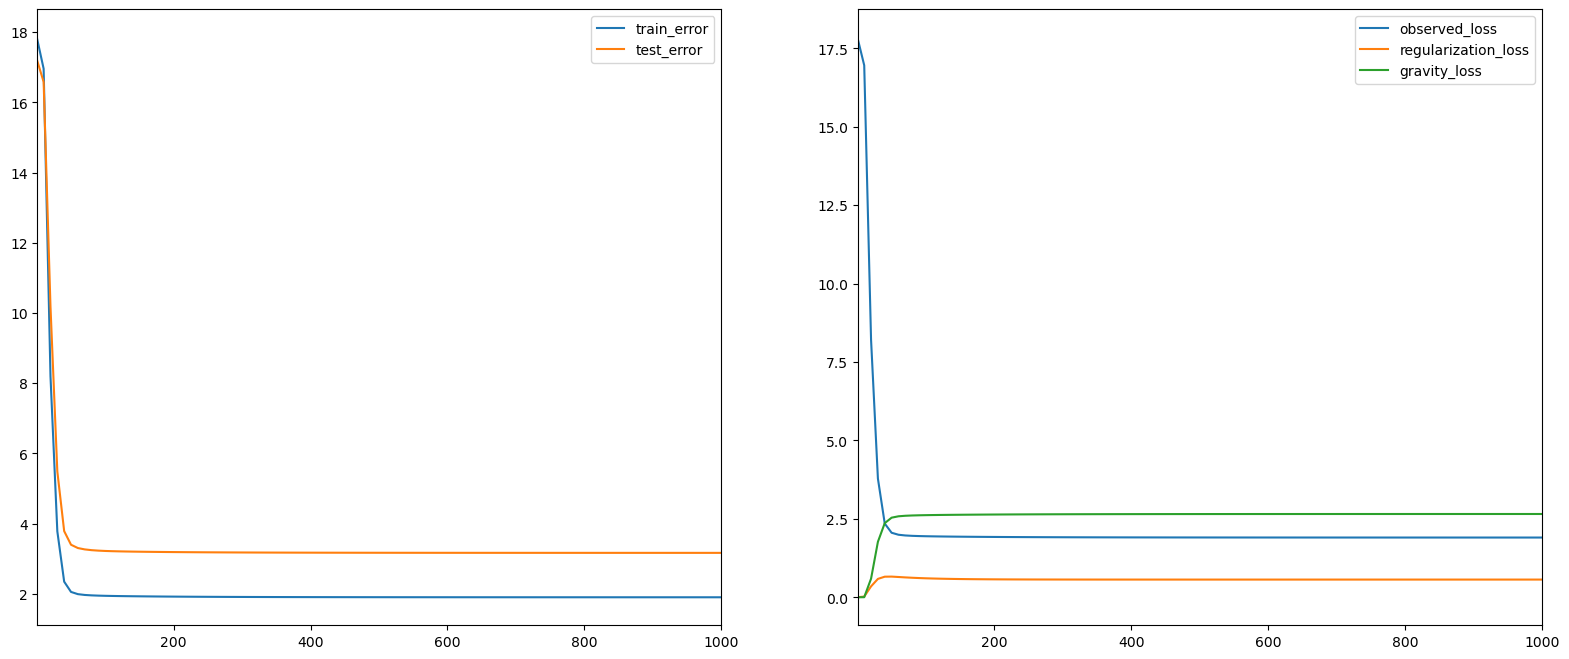

In [15]:
reg_model = build_regularized_model(
    score_df, reg_coef=0.1, grav_coef=1.0, embedding_dim=3,
    init_stddev=.05)
reg_model.train(num_iterations=1000, learning_rate=5.)

In [16]:
def compute_scores(query_embedding,item_embeddings):
    u=query_embedding
    V=item_embeddings
    u=u/np.linalg.norm(u)
    V=V/(np.linalg.norm(V,axis=1,keepdims=True))
    return u.dot(V.T)*10

def get_rec(model,num_desired=10):
    matching_scores=compute_scores(
        model.embeddings["mentee_id"][num_mentee],
        model.embeddings["mentor_id"]
        )
    df=pd.DataFrame({
        "Score":list(matching_scores),
        "Name":df_mentor["name"],
        "mentee_id":df_mentor["mentee_id"],
        "uni":df_mentor["Uni Pref"],
        "Major":df_mentor["Major"],
        "Career":df_mentor["Career_Desciption"],
        "Social":df_mentor["Social_Desciption"]
    })
    display.display(df.sort_values(["Score"],ascending=False).head(num_desired))

In [17]:
#example 1: I really like Busineess Administration at UNI A
df_mentor["Uni Pref"]=df_mentor["Uni Pref"].astype(str)
df_mentor["Major"]=df_mentor["Major"].astype(str)
filtered_mentor = df_mentor.loc[(df_mentor["Uni Pref"]=="Uni A") & (df_mentor["Major"]=="Business Administration")]
filtered_mentor

,name,mentee_id,Career_Vector,Social_Vector,Uni Pref,Major,Career_Desciption,Social_Desciption
75,Harper,75,"[1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, ...",Uni A,Business Administration,Agriculture-Architecture-Communication,Disabilities-Health-International Relations
89,Jack,89,"[0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, ...",Uni A,Business Administration,Business-Entrepreneurship-Military,Environment-Homeless-Poverty
90,Ethan,90,"[0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, ...",Uni A,Business Administration,Communication-Marketing-Music,Disaster ReliefElderly-Environment-Service


In [18]:
score_df=score_df.append({"mentor_id":93,"mentee_id":500,"score":10},ignore_index=True)
score_df=score_df.append({"mentor_id":99,"mentee_id":500,"score":10},ignore_index=True)
score_df=score_df.append({"mentor_id":4,"mentee_id":500,"score":10},ignore_index=True)
score_df=score_df.append({"mentor_id":6,"mentee_id":500,"score":10},ignore_index=True)
score_df=score_df.append({"mentor_id":12,"mentee_id":500,"score":10},ignore_index=True)

/var/folders/_x/fh3t8wcj3_xbs4fddcxmbpc00000gn/T/ipykernel_8968/1851870051.py:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  score_df=score_df.append({"mentor_id":93,"mentee_id":500,"score":10},ignore_index=True)
/var/folders/_x/fh3t8wcj3_xbs4fddcxmbpc00000gn/T/ipykernel_8968/1851870051.py:2: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  score_df=score_df.append({"mentor_id":99,"mentee_id":500,"score":10},ignore_index=True)
/var/folders/_x/fh3t8wcj3_xbs4fddcxmbpc00000gn/T/ipykernel_8968/1851870051.py:3: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  score_df=score_df.append({"mentor_id":4,"mentee_id":500,"score":10},ignore_index=True)
/var/folders/_x/fh3t8wcj3_xbs4fddcxmbpc00000gn/T/ipykernel_8968/1851870051.py:4: FutureWa

 iteration 930: train_error=1.911311, test_error=3.434297, observed_loss=1.911311, regularization_loss=0.568994, gravity_loss=2.697946

 iteration 1000: train_error=1.911258, test_error=3.434101, observed_loss=1.911258, regularization_loss=0.568999, gravity_loss=2.697991

[{'train_error': 1.911258, 'test_error': 3.434101},
 {'observed_loss': 1.911258,
  'regularization_loss': 0.5689985,
  'gravity_loss': 2.6979907}]

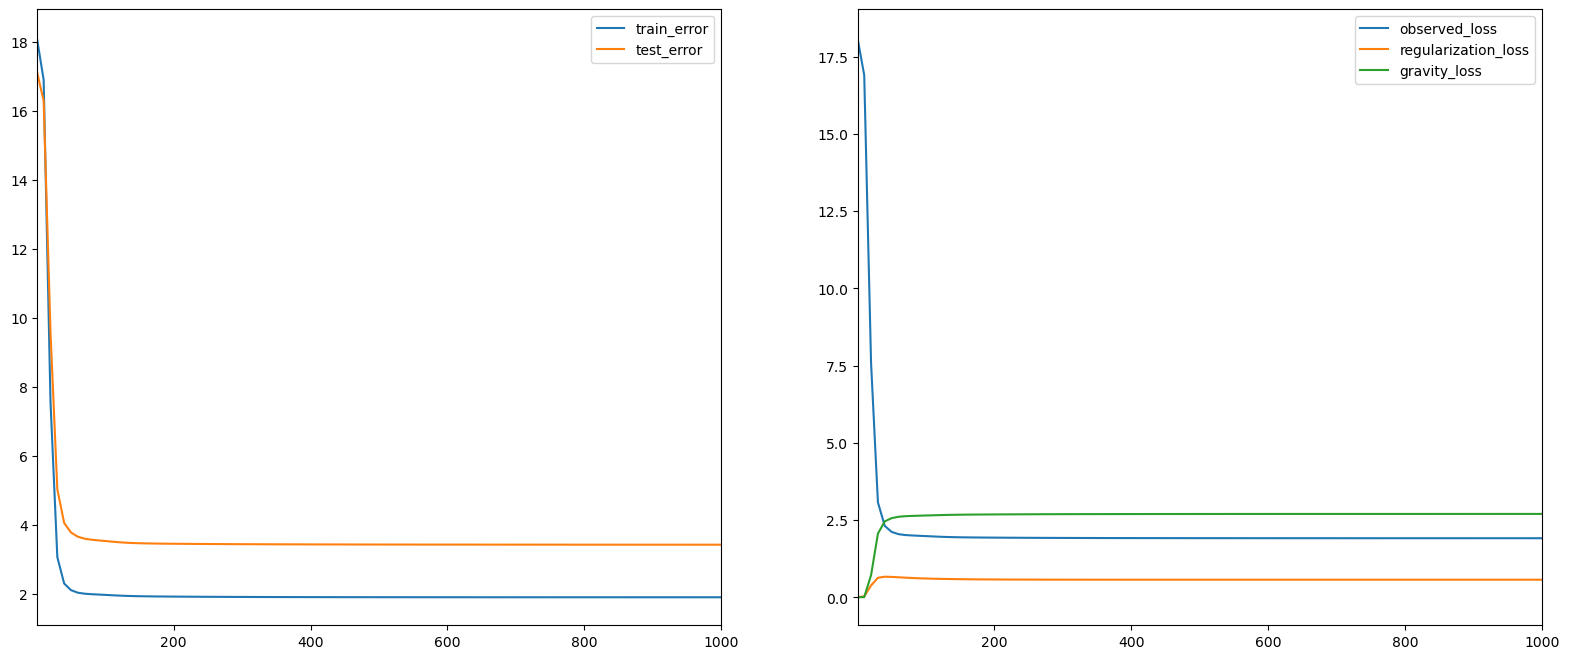

In [19]:
new_model = build_regularized_model(
    score_df, reg_coef=0.1, grav_coef=1.0, embedding_dim=3,
    init_stddev=.05)
new_model.train(num_iterations=1000, learning_rate=5.)

In [21]:
get_rec(new_model)

,Score,Name,mentee_id,uni,Major,Career,Social
99,10.00,Luke,99,Uni A,Finance,Engineering-Military-Public Safety,Environment-Human Rights-Service
12,10.00,Ella,12,Uni B,Economics,Business-Education-Government,Hunger-Military-Women's Issues
93,10.00,Luke,93,Uni C,Engineering,Business-Communication-Education,Animals-Homeless-Military
4,10.00,Michael,4,Uni C,Communications,Agriculture-Entrepreneurship-Government,Disaster ReliefElderly-Human Rights-Research
43,9.83,Daniel,43,Uni B,Psychology,Architecture-Design-Military,Environment-International Relations-Women's Is...
73,9.62,Ava,73,Uni A,Biology,Law-Science-Techonology,Children-Education-International Relations
11,9.51,Grace,11,Uni B,Biology,Design-Engineering-Science,Animals-Disabilities-Hunger
36,9.12,Isabella,36,Uni C,Computer Science,Architecture-Education-Visual Art,Hunger-International Relations-Research
17,8.69,Daniel,17,Uni A,Nursing,Architecture-Design-Government,Education-Hunger-International Relations
59,8.39,James,59,Uni C,Psychology,Architecture-Media-Techonology,Disaster ReliefElderly-Environment-Women's Issues
